In [1]:
import numpy as np
import pandas as pd
import time
import sys
import os

sys.path.append("../")

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

os.environ["OMP_NUM_THREADS"] = "2"

In [3]:
def preprocessing():
    dataset = pd.read_csv("./data/german_credit_data.csv").drop("Unnamed: 0", axis=1)

    dataset.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

    for column in dataset.columns:
        if dataset[column].dtype != np.dtype("int64"):
            dataset[column] = LabelEncoder().fit_transform(dataset[column])

    return dataset


def train_model(x, y, model):
    cv = KFold(n_splits=3, random_state=None)
    global total_cm
    total_cm = np.zeros((2, 2))
    metric_dict = {}
    split_dict = {}

    it = 0
    for train_ind, test_ind in cv.split(x):
        x_train, x_test = x[train_ind], x[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        total_cm += confusion_matrix(y_test, y_pred)

        metrics = [
            accuracy_score(y_test, y_pred) * 100,
            precision_score(y_test, y_pred) * 100,
            recall_score(y_test, y_pred) * 100,
        ]

        metrics = np.round(metrics, decimals=2)

        metric_dict[it] = metrics
        split_dict[it] = (train_ind, test_ind)
        it += 1

    return total_cm, metric_dict, split_dict

In [4]:
dataset = preprocessing()

model = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=22222)
# model2 = LogisticRegression(max_iter = 1000)

cols = dataset.iloc[:, :-1].columns.values
class_names = ["Bad Risk", "No Risk"]
X = dataset.drop(dataset.columns[-1], axis=1).values
Y = dataset.iloc[:, [-1]].values.reshape(-1,)

cm, metrics, splits = train_model(X, Y, model)

x_train, x_test = X[splits[0][0]], X[splits[0][1]]
y_train, y_test = Y[splits[0][0]], Y[splits[0][1]]

In [5]:
model.predict_proba(x_test)[0]

array([0.92, 0.08])

In [6]:
data_maximums = dataset.iloc[:, :-1].max()

discrete_map = np.where(
    data_maximums < 20, 1, 0
)  # Can use np.where(discrete_map == 1, cols, 0)
continuous_map = np.where(data_maximums > 20, 1, 0)
feature_map = {"continuous": continuous_map, "discrete": discrete_map}

In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def split_by_cm(x, y, model, test_size=0.20, plot_cm=False, class_names=None):
        
    cm_dict_x = {"true_neg":[], "false_neg":[], "true_pos":[], "false_pos":[]}
    cm_dict_y = {"true_neg":[], "false_neg":[], "true_pos":[], "false_pos":[]}
    
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=0, stratify = y
        )

    model.fit(x_train, y_train)
    y_prob = model.predict_proba(x_test)
    y_pred = np.argmax(y_prob, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    
    if class_names == None:
        class_names = np.unique(y_pred)
        
    if plot_cm:
        plt.rcParams['font.size'] = '15'
        fig = ConfusionMatrixDisplay(cm, display_labels=class_names)
        fig.plot(cmap="Greens", colorbar=False, xticks_rotation="horizontal")

    for i in range(x_test.shape[0]):
        #Four cases
        if y_test[i] == 1:
            if y_pred[i] == y_test[i]:
                cm_dict_x["true_pos"].append(x_test[i])
                cm_dict_y["true_pos"].append(y_prob[i])
            else:
                cm_dict_x["false_pos"].append(x_test[i])
                cm_dict_y["false_pos"].append(y_prob[i])

        elif y_test[i] == 0:
            if y_pred[i] == y_test[i]:
                cm_dict_x["true_neg"].append(x_test[i])
                cm_dict_y["true_neg"].append(y_prob[i])
            else:
                cm_dict_x["false_neg"].append(x_test[i])
                cm_dict_y["false_neg"].append(y_prob[i])
        else:
            raise AssertionError

    return {"samples":cm_dict_x, "prob":cm_dict_y}

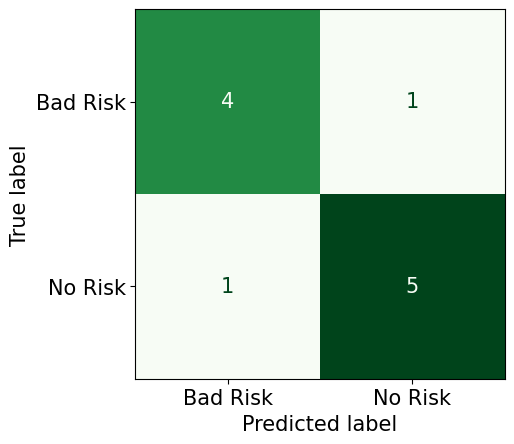

In [8]:
splits = split_by_cm(X, Y, model, test_size=0.02, plot_cm=True, class_names=class_names)

In [9]:
from chweimo.counterfactual import Optimizer

explainer = Optimizer(X, Y, model.predict_proba, col_names=cols)

4it [00:17,  4.35s/it]


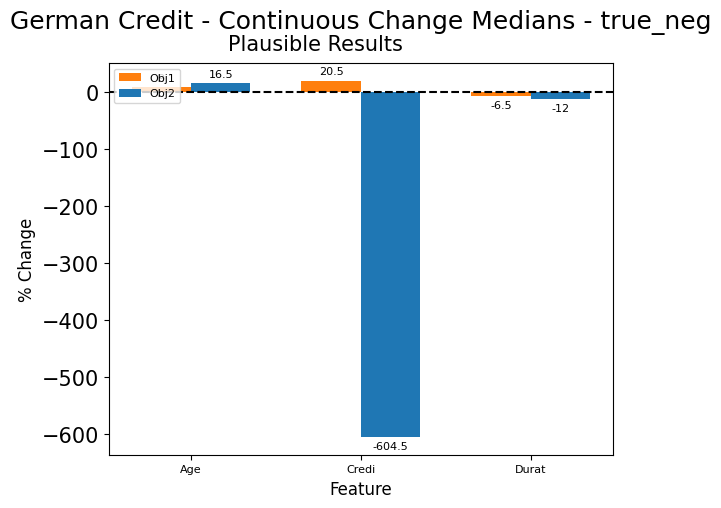

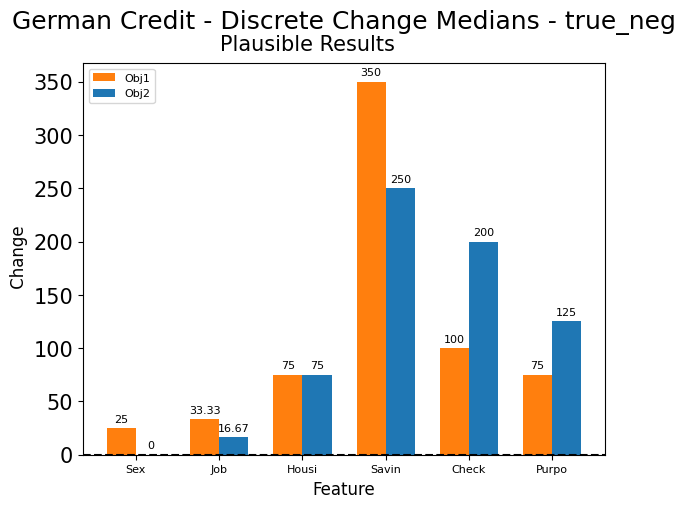

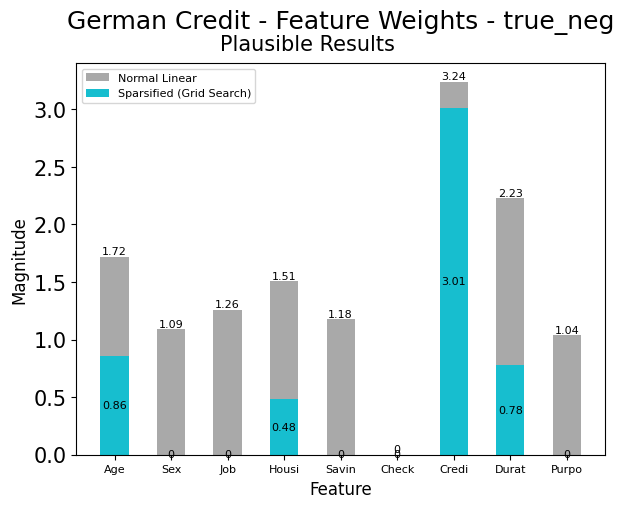

In [10]:
from chweimo.explain_tools import perform_aggregation
test = perform_aggregation(explainer, splits,
                           type_dict=feature_map, termination=10, verbose=False, pop_size=40,
                           data_name="German Credit")